# Customer Behavior Analysis - NYC Bike Rentals

In this project I will analyze bike rental data from New York City to try and find any interesting behavioral patterns between the different customer types. The dataset comes from **TBD** and includes the following columns:

Link to data files - https://s3.amazonaws.com/tripdata/index.html
Link to home page  - https://www.citibikenyc.com/
Link to specific month - TBD

- `tripduration` (int64) - length of rental in seconds
- `starttime` (object) - rental start time
- `stoptime` (object) - rental stop time
- `start station id` (int64) - id of start station 
- `start station name` (object) - name of start station
- `start station latitude` (float64) - latitude of start station
- `start station longitude` (float64) - longitude of start station
- `end station id` (int64) - id of end station
- `end station name` (object) - name of end station
- `end station latitude` (float64) - latitude of end station
- `end station longitude` (float64) - longitude of end station
- `bikeid` (int64) - id of rental bike
- `usertype` (object) - type of user ('Subscriber' or 'Customer')
- `birth year` (object) - birth year of renter (if known)
- `gender` (int64) - gender of renter (if known)


In this exploratory data analysis, I will be looking into behavioral differences between user types.
1. Rental count
2. Rental duration
3. Rentals by station
    1. Which stations are most popular for rentals overall? By day of week? By hour of day? And does this vary by user type?
    2. Station popularity
        1. Which stations are most popular overall? By user type? By day of week? By hour of day?
        2. Which station is most popular for starting a trip? ending a trip?
        3. Which trips are most popular (start station to end station) and how does this vary across our key dimensions (i.e., user type, day of week, hour of day)
        
Let's get started...

## Preparation

Before we get started with the analysis, we need to do some prep work. First, we'll import the required libraries for the project and then we can read in and preview our data set.


### Import Libraries

In [85]:
# Import packages
import math
import scipy.stats as stats
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("whitegrid")
sns.set(color_codes=True)
sns.set(font_scale=1.25)

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

# Setup Bokeh to output directly to the notebook
output_notebook(resources=None, verbose=False, hide_banner=True, load_timeout=5000, notebook_type='jupyter')

import folium

# Set display option for floats in Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Read in & Preview the Data

In [2]:
# Read in the data and review
df = pd.read_csv('../data/bike_rental_data.csv')
print(df.shape)

(1037712, 15)


In [3]:
df.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,326,2013-10-01 00:01:08,2013-10-01 00:06:34,239,Willoughby St & Fleet St,40.69,-73.98,366,Clinton Ave & Myrtle Ave,40.69,-73.97,16052,Subscriber,1982,1


## Data Cleanup and Prep

Now that we have our data in a dataframe and have an idea of what it looks like, let's do a quick review and clean it up a bit before moving into the analysis. 


### Clean Up the Columns

Next, let's move on to updating the column names. For this project we'll be accessing columns using the format of *df.column* so we'll need to remove spaces to facilitate this.

Before we do this though, we'll remove a couple of the columns that won't be necessary for our behavior analysis.

- **bikeid** - Assuming bikes are chosen at random, bikeid won't be relevant for this analysis
- **gender** - Gender isn't tracked for casual customers, so it won't be useful to us in this analysis
- **birth year** - Similar to gender, birth year is also not tracked for casual customers

In [4]:
# Drop unnecessary columns
df = df.drop(['bikeid', 'gender', 'birth year'], axis=1)

# Rename columns to remove spaces
cols = []
for col in df.columns.to_list():
    col = col.replace(' ','_')
    cols.append(col)
df.columns = cols
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'usertype'],
      dtype='object')

### Review & Cleanup Duration Data

Based on the data dictionary above, we can see that the duration data is in seconds. While this is great for precision, it's probably overkill for the type of general analysis we'll do in this project. 

In addition, converting to minutes will help improve the readability of the plots we produce later on since people have pretty good intuition about time values in minutes, but struggle with making the conversion from seconds to minutes on their own.

After we make the conversion, we can take a quick look at some basic statistics for the data.

#### Convert Duration to Minutes

In [5]:
# Update the tripduration column to minutes, rounded to the nearest minute
df['tripduration'] = round((df.tripduration / 60),0).astype(int)

In [6]:
df.tripduration.describe()

count   1037712.00
mean         13.76
std          33.34
min           1.00
25%           7.00
50%          10.00
75%          17.00
max       20991.00
Name: tripduration, dtype: float64

In [7]:
df[df.tripduration > 50].tripduration.count()

10763

#### Review and Adjust Duration Data Range
Looking at the statistics above, our data appears to be skewed on the high end, with 75% of trips coming in at 17 min or less and a maximum trip duration of nearly 21000 minutes! While this is an impressive feat of bike riding, it will probably continue to skew our analysis if we don't remove some of the outliers on the higher end. 

Based on the above, it looks like trips over 50 min only account for a little over 1% of our 1 million rows. We should be able to safely remove these to get a more representative sample of the data. Let's filter out the rows with durations over 50 and then take another look at the distribution.

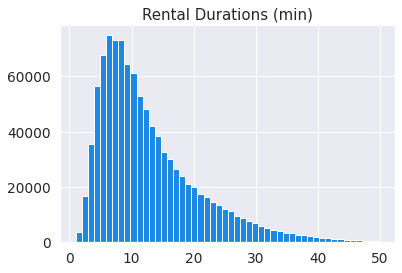

In [8]:
# Remove outlier trips with above 50 min
df = df[df.tripduration <= 50]

# And now to plot duration on a histogram using the adjusted df
plt.hist(df.tripduration, bins=50, range=(1,50), color='#1E88E5')
plt.title('Rental Durations (min)');

In [9]:
# And to review our duration stats again
df.tripduration.describe()

count   1026949.00
mean         12.59
std           8.34
min           1.00
25%           7.00
50%          10.00
75%          16.00
max          50.00
Name: tripduration, dtype: float64

Looking at the result, the standard deviation is now much more reasonable when compared to the mean. After removing the outlier trips, we can see that the average trip is just over 12 min min length and our row count is still at 1026949 as compared to 1037712. So we managed to preserve 98.96% of our data in the process.

### Clean Up Date Columns
Our data set includes 2 columns containing datetime information, but the data is stored in str format. Let's start by converting these columns to datetime format. Then, following this conversion, we'll extract some additional date related info to aid us in our analysis later on. 

To do this, we will create 3 new columns:

- **hour** - Extract hour of the day as int (i.e, 0 - 23, 0 = Midnight)
- **dow** - Extract day of the week as int (i.e., 0 = Monday, 6 = Sunday)
- **date** - Extract the date (e.g., '2013-10-01')

In [10]:
# Convert start_date and end_date to datetime format
df.starttime = pd.to_datetime(df.starttime, infer_datetime_format=True)
df.stoptime = pd.to_datetime(df.stoptime, infer_datetime_format=True)

# Create new columns for hour, day of week and date of rental
df["hour"] = df.starttime.dt.hour
df["dow"] = df.starttime.dt.dayofweek
df['date'] = df['starttime'].dt.date


## Behavior Analysis

Now that we have our data cleaned up and ready to go, we can start working through our list of questions to get a better understanding of the differences between our two user types. 



### User Type High Level Analysis

First, let's get a high level view of a couple of our key metrics - rental count and average rental duration - and see how this breaks down between our user types.

In [11]:
# Create new "count" column to aid in aggregation
df['count'] = 1

# Determine average duration for subscriber vs. customer
df.pivot_table(index=["usertype"], values=["count","tripduration"],\
               aggfunc={"count": np.sum,"tripduration": np.mean}).\
               sort_values("tripduration", ascending=False)

,count,tripduration
usertype,,
Customer,90975,19.24
Subscriber,935974,11.94



### Rental Count by Hour

In the summary above, we can see that it looks like subscribers rent bikes at a rate of about 10x more than casual customers. However, Customer rentals last nearly twice as long on average.  

Next, let's drill into rental count by hour of the day to see if there are any interesting patterns in behavior between the two groups.

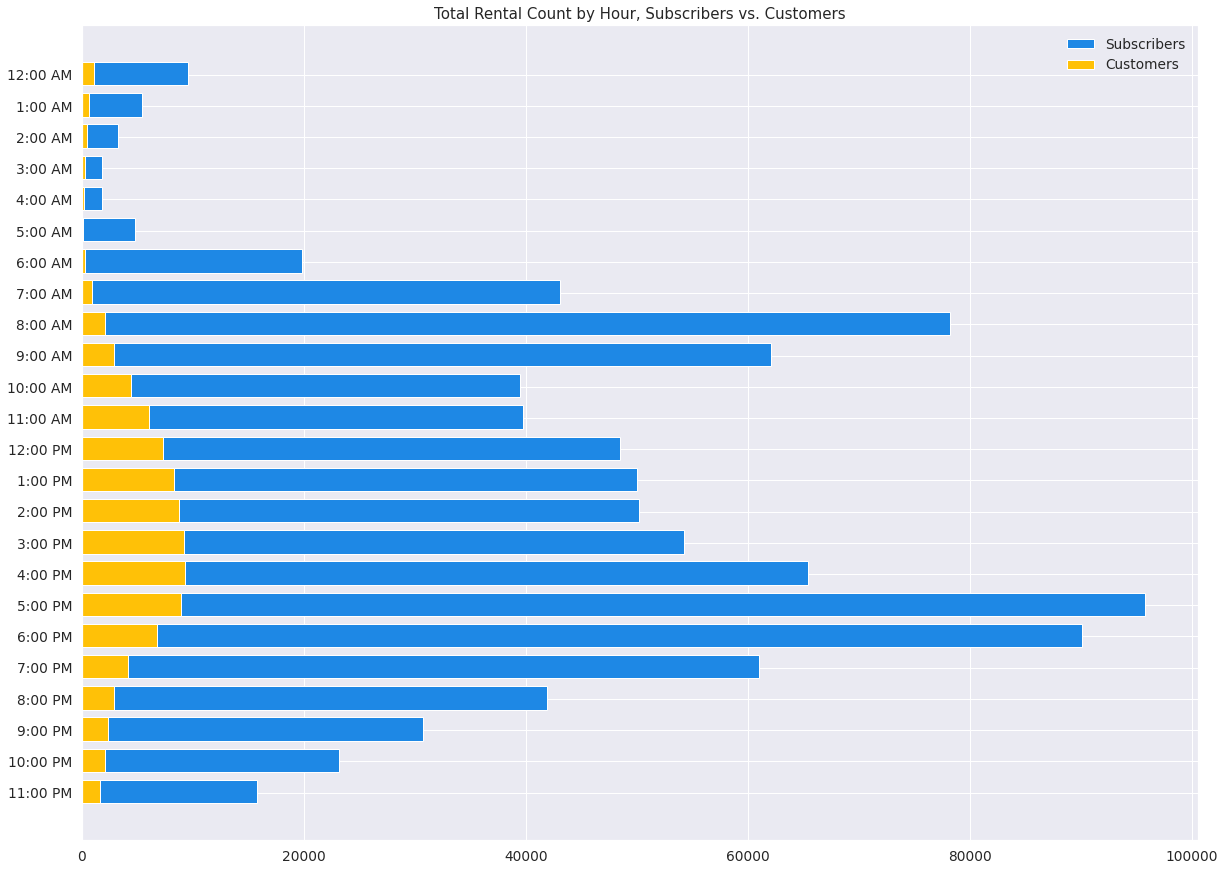

In [12]:
# The y values are the unique list of hours
hours = df.hour.unique().tolist()

# The x values are the sum of the count for each hour of the day
sub_rentals_per_hour = df[df.usertype == 'Subscriber'].groupby(['hour']).hour.count()
x_values_sub = sub_rentals_per_hour.tolist()
cus_rentals_per_hour = df[df.usertype == 'Customer'].groupby(['hour']).hour.count()
x_values_cus = cus_rentals_per_hour.tolist()

# Plot rentals based on the hour of the day
width = 0.75 # width of the bars 
ind = np.arange(len(sub_rentals_per_hour))  # the x locations for the groups
plt.figure(figsize=(20,15))

# Plot the data for subscribers and customers
plt.barh(ind, x_values_sub, width, color='#1E88E5', label='Subscribers')
plt.barh(ind, x_values_cus, width, color='#FFC107', label='Customers')

# Generate friendly labels
ylabels = ['12:00 AM', '1:00 AM', '2:00 AM', '3:00 AM', '4:00 AM', '5:00 AM', '6:00 AM', '7:00 AM',\
           '8:00 AM', '9:00 AM', '10:00 AM', '11:00 AM', '12:00 PM', '1:00 PM', '2:00 PM', '3:00 PM',\
           '4:00 PM', '5:00 PM', '6:00 PM', '7:00 PM', '8:00 PM', '9:00 PM', '10:00 PM', '11:00 PM']

# Additional formatting
plt.yticks(ind+width/24, labels=ylabels)
plt.title('Total Rental Count by Hour, Subscribers vs. Customers')     
plt.gca().invert_yaxis() # account for default reversal of the y axis values
plt.legend(loc='upper right');

plt.show()


Subscriber rentals tend to spike around peak commute hours, between 7:00-10:00 AM and 4:00-7:00 PM. In contrast, rentals by casual customers follow more of a normal distribution throughout the day plateauing between the hours of 1:00 PM and 6:00 PM. 



### Rental Count by Day of Week

Next, let's compare rental counts by day of the week to see if any weekly trends are apparent. To do this, we'll stick with a similar output format for consistency.

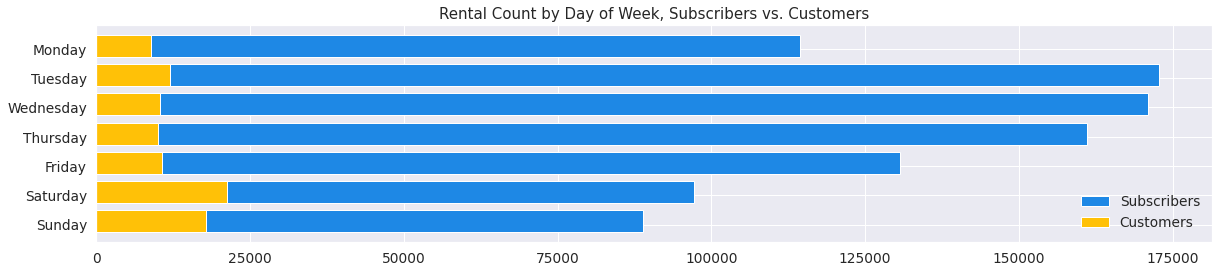

In [13]:
# The y values are the unique list of hours
days = df.dow.unique().tolist()

# The x values are the sum of the count for each hour of the day
sub_rentals_per_day = df[df.usertype == 'Subscriber'].groupby(['dow']).dow.count()
x_values_sub = sub_rentals_per_day.tolist()
cus_rentals_per_day = df[df.usertype == 'Customer'].groupby(['dow']).dow.count()
x_values_cus = cus_rentals_per_day.tolist()

# Plot rentals based on the day of the week
width = 0.75 # width of the bars 
ind = np.arange(len(sub_rentals_per_day))  # the x locations for the groups
plt.figure(figsize=(20,4))

# Plot the data for subscribers and customers
plt.barh(ind, x_values_sub, width, color='#1E88E5', label='Subscribers')
plt.barh(ind, x_values_cus, width, color='#FFC107', label='Customers')

# Generate friendly labels
ylabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Additional formatting
plt.yticks(ind+width/7, labels=ylabels)
plt.title('Rental Count by Day of Week, Subscribers vs. Customers')     
plt.gca().invert_yaxis() # account for default reversal of the y axis values
plt.legend(loc='lower right');

plt.show()


Again, we see opposite behavior patterns between subscribers and customers in this view. For subscribers, rental counts are higher on weekdays as compared to weekends. Monday and Friday are not as high as Tuesday through Thursday, but this could likely be attributed to more people taking these days off or working from home.

For customers, we see similar counts Monday through Friday with a peak over the weekend days.


### Rentals Per Day Over Time

As a next step in our analysis, let's take a look at the rental count data over time to see if this backs up our initial assertions above regarding behavioral differences between customers and subscribers.

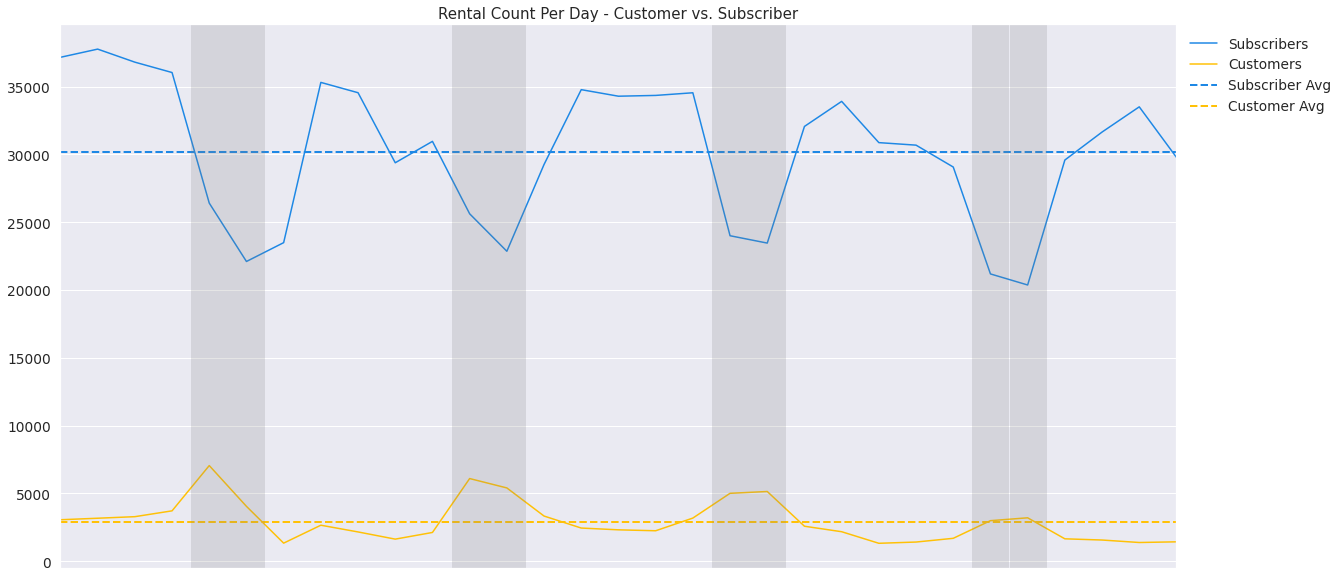

In [14]:
###
# TODO
# 1. Figure out how to label the weekend bars and determine if adjustment is needed to placement
# 2. Adjust labels on x-axis to show all 31 days
###

# The x values are the unique list of dates (2013-10-1 - 2013-10-31)
x_values = df.date.unique().tolist()

# The y values are the rental counts for each user type
y_values_sub = df[df['usertype'] == 'Subscriber'].groupby(['date']).usertype.count()
y_values_cus = df[df['usertype'] == 'Customer'].groupby(['date']).usertype.count()

# Create the figure and plot the lines for each user type
plt.figure(figsize=(20,10))
g = sns.lineplot(x_values, y_values_sub, color='#1E88E5', label='Subscribers')
sns.lineplot(x_values, y_values_cus, color='#FFC107', label='Customers')

# Plot horizontal lines to show the average daily rental count for each group
plt.axhline(y_values_sub.mean(), color='#1E88E5', linestyle='dashed', linewidth=2, label='Subscriber Avg')
plt.axhline(y_values_cus.mean(), color='#FFC107', linestyle='dashed', linewidth=2, label='Customer Avg')

# Create a list of weekend dates
weekends = []
for date in x_values:
    if date.weekday() >= 5:
        weekends.append(date)

# Plot a vertical gray bar to designate weekend days
for date in weekends:
    plt.axvline(date, color='gray', alpha=0.2, linewidth=37) # linewidth based on trial and error

# Add limits, labels and title
g.set_xticks(range(1,32,1))
g.set_xticklabels = [item.day for item in x_values]
g.set_xlim(df.date.min(), df.date.max())
g.set(xlabel=None, ylabel=None,
      title='Rental Count Per Day - Customer vs. Subscriber')
g.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=1);


### Rental Duration

Next on our list is to take a look at rental duration between our two customer groups. Based on our quick analysis at the start, we know the average rental duration is twice as high for casual customers as it is for subscribers, but let's take a closer look at the distribution of rental durations for each group.


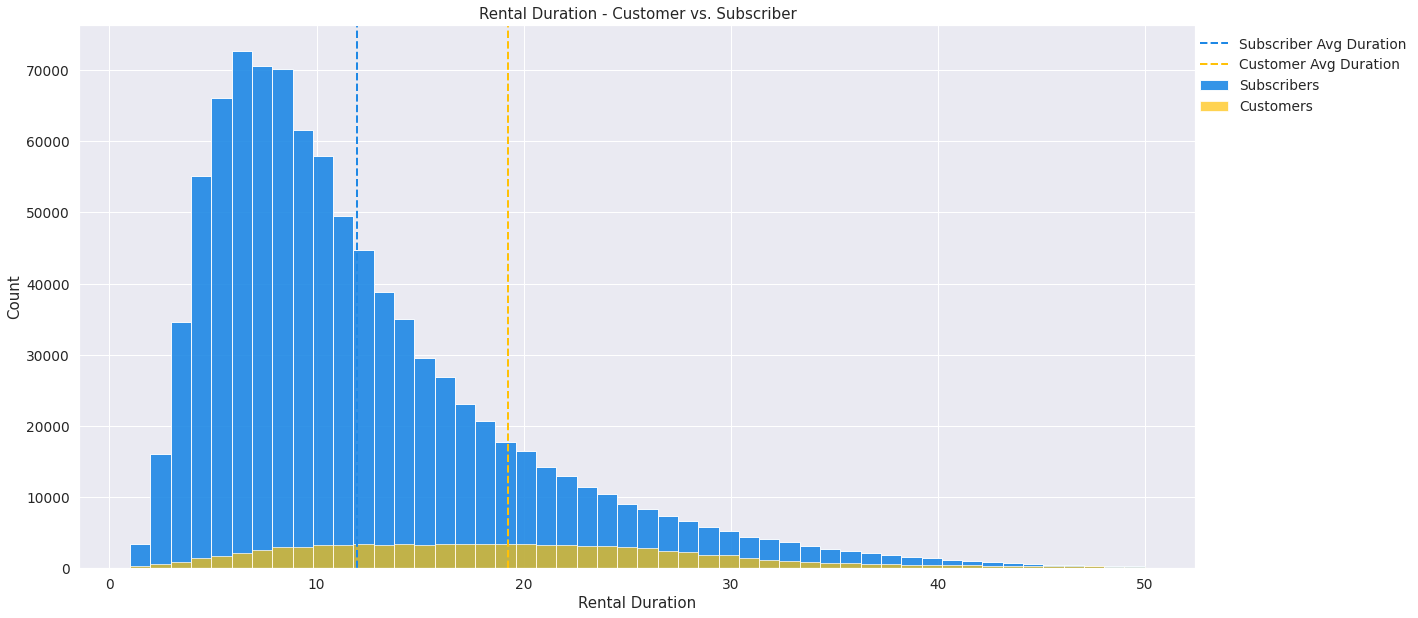

In [15]:
# Plot a histogram of avg rental duration for customers vs. subscribers
x_cus = df[df['usertype'] == 'Customer'].tripduration
x_sub = df[df['usertype'] == 'Subscriber'].tripduration

plt.figure(figsize=(20,10))

# plot histogram for each type
plt.hist(x_sub, bins=50, range=(1,50), color='#1E88E5', alpha=0.9, label='Subscribers')
plt.hist(x_cus, bins=50, range=(1,50), color='#FFC107', alpha=0.7, label='Customers')

# plot the average for each type
plt.axvline(x_sub.mean(), color='#1E88E5', linestyle='dashed', linewidth=2, label='Subscriber Avg Duration')
plt.axvline(x_cus.mean(), color='#FFC107', linestyle='dashed', linewidth=2, label='Customer Avg Duration')

# Formatting and Labels
plt.xlabel("Rental Duration")
plt.ylabel("Count")
plt.title('Rental Duration - Customer vs. Subscriber')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1);

TODO - FINISH WRITING UP CONCLUSIONS

Based on the data for this single month, it looks like we can start to draw some tentative conclusions.

1. Subscribers are much more likely to rent bikes in general (TODO - add avg rental count per day)
2. Customers rent bikes for nearly twice as long on average (19 min as compared to 12 min for subscribers)
3. Subscriber rentals peak on weekdays (in particular Tuesday - Thursday) and Customer rentals peak on weekends.

Assuming subscribers are paying some sort of monthly subscription fee in addition to a per min rate, it would appear that the best way to increase revenue for the program would be to increase the number of subscribers. Although, without exact numbers for the program, this is a tough conclusion to make. 

If subscribers pay a monthly fee that **includes** a specified amount of minutes, this could explain why the average duration is lower for subscribers who may not want to exceed their monthly allocation. In contrast, as a one-off customer, it is likely a bigger decision to rent a bike to begin with and it's reasonable to think that these rentals occur most frequently when a person has a long distance to travel - i.e., a distance so long that they would prefer to ride than walk.

## Station Popularity

### Start Station Popularity - By Rental Count

TODOs
- Add introduction
- Add summary of findings
- Fix map popup formatting to be a min width and also to include name and count

In [16]:
# Create a function to add markers to map
def addMarkers(df, color, lat, long, popup, radius, radius_factor):
    for i in range(0,len(sub_start_stations)):
        folium.Circle(
          location=[df.iloc[i][lat], df.iloc[i][long]],
          popup=df.iloc[i][popup],
          popup_width=(1000),
          radius=float(df.iloc[i][radius]*radius_factor), # can make larger by adding a multiplier (e.g. * 10) 
          color=color,
          fill=True,
          fill_color=color).add_to(m)

In [17]:
# Create new dfs for popular start stations by user_type
sub_start_stations = df[df.usertype == 'Subscriber'].pivot_table(index=['usertype','start_station_name',\
                               'start_station_longitude', 'start_station_latitude'], values='count',\
                               aggfunc=np.sum).sort_values("count", ascending=False).reset_index().head(10)

cus_start_stations = df[df.usertype == 'Customer'].pivot_table(index=['usertype', 'start_station_name',\
                               'start_station_longitude', 'start_station_latitude'], values='count',\
                               aggfunc=np.sum).sort_values("count", ascending=False).reset_index().head(10)

# Top 10 start stations by user type
pd.concat([sub_start_stations[['usertype','start_station_name','count']],\
           cus_start_stations[['usertype','start_station_name','count']]], axis=1)

,usertype,start_station_name,count,usertype,start_station_name,count
0,Subscriber,Pershing Square N,10558,Customer,Centre St & Chambers St,1577
1,Subscriber,8 Ave & W 31 St,10333,Customer,West St & Chambers St,1434
2,Subscriber,E 17 St & Broadway,9777,Customer,Central Park S & 6 Ave,1351
3,Subscriber,Lafayette St & E 8 St,9764,Customer,Grand Army Plaza & Central Park S,1118
4,Subscriber,W 20 St & 11 Ave,8764,Customer,W 20 St & 11 Ave,953
5,Subscriber,Broadway & E 14 St,8356,Customer,Broadway & W 24 St,878
6,Subscriber,University Pl & E 14 St,8351,Customer,12 Ave & W 40 St,846
7,Subscriber,W 21 St & 6 Ave,7619,Customer,9 Ave & W 14 St,828
8,Subscriber,2 Ave & E 31 St,7366,Customer,Broadway & W 58 St,781
9,Subscriber,Broadway & E 22 St,7251,Customer,8 Ave & W 31 St,775


In [18]:
# Make an empty map
m = folium.Map(location=[40.72,-73.99], tiles='cartodbpositron', zoom_start=12.5)

# Add markers to map
### INCLUDES AN EXAMPLE OF MULTIPLE FIELDS IN POPUP
addMarkers(sub_start_stations, '#1E88E5', 'start_station_latitude', 'start_station_longitude',\
           ['start_station_name','count'], 'count', 0.02)
addMarkers(cus_start_stations, '#FFC107', 'start_station_latitude', 'start_station_longitude',\
           'start_station_name', 'count', 0.1)

# Show the map
m


### End Station Popularity - By Rental Count


In [19]:
# Create new dfs for popular end stations by user_type
sub_end_stations = df[df.usertype == 'Subscriber'].pivot_table(index=['usertype','end_station_name',\
                               'end_station_longitude', 'end_station_latitude'], values='count',\
                               aggfunc=np.sum).sort_values('count', ascending=False).reset_index().head(10)

cus_end_stations = df[df.usertype == 'Customer'].pivot_table(index=['usertype','end_station_name',\
                               'end_station_longitude', 'end_station_latitude'], values='count',\
                               aggfunc=np.sum).sort_values('count', ascending=False).reset_index().head(10)

# Top 10 end stations by user type
pd.concat([sub_end_stations[['usertype','end_station_name','count']],\
           cus_end_stations[['usertype','end_station_name','count']]], axis=1)

,usertype,end_station_name,count,usertype,end_station_name,count
0,Subscriber,8 Ave & W 31 St,10511,Customer,Centre St & Chambers St,1923
1,Subscriber,E 17 St & Broadway,10418,Customer,Central Park S & 6 Ave,1711
2,Subscriber,Lafayette St & E 8 St,9662,Customer,West St & Chambers St,1690
3,Subscriber,W 20 St & 11 Ave,9009,Customer,Grand Army Plaza & Central Park S,1276
4,Subscriber,University Pl & E 14 St,8302,Customer,Broadway & W 60 St,1106
5,Subscriber,Broadway & E 14 St,8137,Customer,W 20 St & 11 Ave,947
6,Subscriber,Pershing Square N,8128,Customer,12 Ave & W 40 St,872
7,Subscriber,Greenwich Ave & 8 Ave,7414,Customer,W 14 St & The High Line,840
8,Subscriber,Broadway & E 22 St,7236,Customer,E 17 St & Broadway,824
9,Subscriber,2 Ave & E 31 St,7199,Customer,9 Ave & W 14 St,822


In [20]:
# Make an empty map
m = folium.Map(location=[40.72,-73.99], tiles='cartodbpositron', zoom_start=12.5)

# Add markers to map
addMarkers(sub_end_stations, '#1E88E5', 'end_station_latitude', 'end_station_longitude',\
           'end_station_name', 'count', 0.025)
addMarkers(cus_end_stations, '#FFC107', 'end_station_latitude', 'end_station_longitude',\
           'end_station_name', 'count', 0.10)

# Show the map
m

## Start Station Popularity - Avg Rental Duration - Top 10

In [21]:
# Create new dfs for popular start stations by user_type
sub_start_top_dur = df[df.usertype == 'Subscriber'].pivot_table(index=['usertype','start_station_name',\
                               'start_station_longitude', 'start_station_latitude'], values='tripduration',\
                               aggfunc=np.mean).sort_values('tripduration', ascending=False).reset_index().head(10)

cus_start_top_dur = df[df.usertype == 'Customer'].pivot_table(index=['usertype', 'start_station_name',\
                               'start_station_longitude', 'start_station_latitude'], values='tripduration',\
                               aggfunc=np.mean).sort_values('tripduration', ascending=False).reset_index().head(10)

# Top 10 start stations by user type
pd.concat([sub_start_top_dur[['usertype','start_station_name','tripduration']],\
           cus_start_top_dur[['usertype','start_station_name','tripduration']]], axis=1)

,usertype,start_station_name,tripduration,usertype,start_station_name,tripduration
0,Subscriber,Wythe Ave & Metropolitan Ave,19.81,Customer,Central Park S & 6 Ave,26.54
1,Subscriber,Dean St & 4 Ave,19.77,Customer,Avenue D & E 12 St,26.27
2,Subscriber,State St,19.61,Customer,Metropolitan Ave & Bedford Ave,24.28
3,Subscriber,S 5 Pl & S 4 St,19.47,Customer,Grand Army Plaza & Central Park S,24.07
4,Subscriber,South St & Whitehall St,18.76,Customer,Broadway & W 60 St,23.34
5,Subscriber,South St & Gouverneur Ln,18.66,Customer,Wythe Ave & Metropolitan Ave,23.33
6,Subscriber,Atlantic Ave & Furman St,18.39,Customer,Centre St & Chambers St,23.28
7,Subscriber,Grand St & Havemeyer St,18.30,Customer,Pearl St & Anchorage Pl,23.14
8,Subscriber,Central Park S & 6 Ave,18.28,Customer,Henry St & Poplar St,23.11
9,Subscriber,Old Fulton St,17.60,Customer,Henry St & Atlantic Ave,23.09


In [22]:
# Make an empty map
m = folium.Map(location=[40.72,-73.99], tiles='cartodbpositron', zoom_start=12)

# Add markers to map
addMarkers(sub_start_top_dur, '#1E88E5', 'start_station_latitude', 'start_station_longitude',\
           'start_station_name', 'tripduration', 10)
addMarkers(cus_start_top_dur, '#FFC107', 'start_station_latitude', 'start_station_longitude',\
           'start_station_name', 'tripduration', 10)

# Show the map
m

## Start Station Popularity - Avg Rental Duration - Bottom 10

In [23]:
# Create new dfs for popular start stations by user_type
sub_start_bottom_dur = df[df.usertype == 'Subscriber'].pivot_table(index=['usertype','start_station_name',\
                               'start_station_longitude', 'start_station_latitude'], values='tripduration',\
                               aggfunc=np.mean).sort_values('tripduration').reset_index().head(10)

cus_start_bottom_dur = df[df.usertype == 'Customer'].pivot_table(index=['usertype', 'start_station_name',\
                               'start_station_longitude', 'start_station_latitude'], values='tripduration',\
                               aggfunc=np.mean).sort_values('tripduration').reset_index().head(10)

# Bottom 10 start stations by user type
pd.concat([sub_start_bottom_dur[['usertype','start_station_name','tripduration']],\
           cus_start_bottom_dur[['usertype','start_station_name','tripduration']]], axis=1)

,usertype,start_station_name,tripduration,usertype,start_station_name,tripduration
0,Subscriber,Willoughby St & Fleet St,7.93,Customer,Cumberland St & Lafayette Ave,10.33
1,Subscriber,DeKalb Ave & Vanderbilt Ave,8.62,Customer,E 12 St & 3 Ave,14.40
2,Subscriber,Adelphi St & Myrtle Ave,8.99,Customer,W 13 St & 6 Ave,14.62
3,Subscriber,DeKalb Ave & Hudson Ave,9.14,Customer,Railroad Ave & Kay Ave,14.83
4,Subscriber,Myrtle Ave & St Edwards St,9.29,Customer,W 21 St & 6 Ave,15.00
5,Subscriber,DeKalb Ave & S Portland Ave,9.51,Customer,Hanover Pl & Livingston St,15.38
6,Subscriber,Washington Square E,9.55,Customer,W 20 St & 7 Ave,15.46
7,Subscriber,Cumberland St & Lafayette Ave,9.70,Customer,W 44 St & 5 Ave,15.48
8,Subscriber,Washington Park,9.72,Customer,6 Ave & W 33 St,15.66
9,Subscriber,Clermont Ave & Park Ave,9.73,Customer,E 16 St & 5 Ave,15.77


In [24]:
# Make an empty map
m = folium.Map(location=[40.72,-73.99], tiles='cartodbpositron', zoom_start=13)

# Add markers to map
addMarkers(sub_start_bottom_dur, '#1E88E5', 'start_station_latitude', 'start_station_longitude',\
           'start_station_name', 'tripduration', 10)
addMarkers(cus_start_bottom_dur, '#FFC107', 'start_station_latitude', 'start_station_longitude',\
           'start_station_name', 'tripduration', 10)

# Show the map
m

### Most Popular Routes

In [25]:
df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,usertype,hour,dow,date,count
0,5,2013-10-01 00:01:08,2013-10-01 00:06:34,239,Willoughby St & Fleet St,40.69,-73.98,366,Clinton Ave & Myrtle Ave,40.69,-73.97,Subscriber,0,1,2013-10-01,1
1,12,2013-10-01 00:01:21,2013-10-01 00:13:30,322,Clinton St & Tillary St,40.70,-73.99,398,Atlantic Ave & Furman St,40.69,-74.00,Customer,0,1,2013-10-01,1
2,9,2013-10-01 00:01:24,2013-10-01 00:10:04,174,E 25 St & 1 Ave,40.74,-73.98,403,E 2 St & 2 Ave,40.73,-73.99,Subscriber,0,1,2013-10-01,1
3,5,2013-10-01 00:01:25,2013-10-01 00:06:06,430,York St & Jay St,40.70,-73.99,323,Lawrence St & Willoughby St,40.69,-73.99,Subscriber,0,1,2013-10-01,1
4,3,2013-10-01 00:01:27,2013-10-01 00:04:43,403,E 2 St & 2 Ave,40.73,-73.99,401,Allen St & Rivington St,40.72,-73.99,Subscriber,0,1,2013-10-01,1


In [26]:
# Make an empty map
m = folium.Map(location=[40.72,-73.99], tiles='cartodbpositron', zoom_start=13)

routes = [((40.69, -73.98),(40.69, -73.97))] 
# add a markers
for route in routes:
    for point in route:  
        folium.CircleMarker(point, color="red").add_to(m)
#         folium.CircleMarker(point[0][0], color="green").add_to(m)
#         folium.CircleMarker(point[0][1], color="red").add_to(m)
        folium.PolyLine(routes, color="black", weight=2.5, opacity=1).add_to(m)

# Show the map
m

In [27]:
# IDEA - Chloropleth map showing zip codes with highest and lowest usage by rental count

In [79]:
df['location'] = list(zip(df['start_station_latitude'], df['start_station_longitude']))
df['location'].head()

0          (40.69196566, -73.9813018)
1    (40.696191999999996, -73.991218)
2          (40.7381765, -73.97738662)
3          (40.7014851, -73.98656928)
4         (40.72502876, -73.99069656)
Name: location, dtype: object

In [83]:
# Function to convert lat, long to mercator (adapted from Colin Patrick Reid, Towards Data Science)
def merc(location):
    lat = location[0]
    lon = location[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

# Convert lat, lon to Mercator coordinates
df['coords_x'] = df['location'].apply(lambda x: merc(x)[0])
df['coords_y'] = df['location'].apply(lambda x: merc(x)[1])

In [95]:
# Create new dfs for popular start stations by user_type
sub_start_bottom_dur = df[df.usertype == 'Subscriber'].\
                        pivot_table(index=['usertype', 'start_station_name', 'coords_x', 'coords_y'],
                        values='tripduration', aggfunc=np.mean).sort_values('tripduration').\
                        reset_index().head(10)

cus_start_bottom_dur = df[df.usertype == 'Customer'].\
                        pivot_table(index=['usertype', 'start_station_name', 'coords_x', 'coords_y'],
                        values='tripduration', aggfunc=np.mean).sort_values('tripduration').\
                        reset_index().head(10)

# Bottom 10 start stations by user type
pd.concat([sub_start_bottom_dur[['usertype','start_station_name','tripduration']],\
           cus_start_bottom_dur[['usertype','start_station_name','tripduration']]], axis=1)

,usertype,start_station_name,tripduration,usertype,start_station_name,tripduration
0,Subscriber,Willoughby St & Fleet St,7.93,Customer,Cumberland St & Lafayette Ave,10.33
1,Subscriber,DeKalb Ave & Vanderbilt Ave,8.62,Customer,E 12 St & 3 Ave,14.40
2,Subscriber,Adelphi St & Myrtle Ave,8.99,Customer,W 13 St & 6 Ave,14.62
3,Subscriber,DeKalb Ave & Hudson Ave,9.14,Customer,Railroad Ave & Kay Ave,14.83
4,Subscriber,Myrtle Ave & St Edwards St,9.29,Customer,W 21 St & 6 Ave,15.00
5,Subscriber,DeKalb Ave & S Portland Ave,9.51,Customer,Hanover Pl & Livingston St,15.38
6,Subscriber,Washington Square E,9.55,Customer,W 20 St & 7 Ave,15.46
7,Subscriber,Cumberland St & Lafayette Ave,9.70,Customer,W 44 St & 5 Ave,15.48
8,Subscriber,Washington Park,9.72,Customer,6 Ave & W 33 St,15.66
9,Subscriber,Clermont Ave & Park Ave,9.73,Customer,E 16 St & 5 Ave,15.77


In [102]:
# Plot a map view of rental stations
tile_provider = get_provider(CARTODBPOSITRON)
p = figure(plot_width=800,plot_height=600, x_range=(-8235000, -8240000), y_range=(4966000, 4978000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

# Plot station markers 
p.circle(x=sub_start_bottom_dur['coords_x'],
         y=sub_start_bottom_dur['coords_y'],
         size=sub_start_bottom_dur['tripduration']*2,
         line_color='#1E88E5',
         line_width=3,
         fill_color='#1E88E5',
         fill_alpha=0.05)

p.circle(x=cus_start_bottom_dur['coords_x'],
         y=cus_start_bottom_dur['coords_y'],
         size=cus_start_bottom_dur['tripduration']*2,
         line_color='#FFC107',
         line_width=3,
         fill_color='#FFC107',
         fill_alpha=0.05)

### TODO
# Add legend and HoverTool

show(p)